In [1]:
#|hide
from fastrl.test_utils import initialize_notebook
initialize_notebook()

In [2]:
#|default_exp agents.ppo

In [3]:
#|export
# Python native modules
from typing import Union,Dict,Literal,List
# Third party libs
import torch
from torch import nn
import torchdata.datapipes as dp 
from torchdata.dataloader2.graph import DataPipe
from torch.optim import AdamW,Adam
# # Local modules
from fastrl.core import SimpleStep
from fastrl.layers import Critic
from fastrl.agents.trpo import Actor
from fastrl.loggers.core import ProgressBarLogger
from fastrl.loggers.vscode_visualizers import VSCodeDataPipe
from fastrl.learner.core import LearnerBase,LearnerHead
from fastrl.loggers.core import BatchCollector,EpochCollector,RollingTerminatedRewardCollector,EpisodeCollector
import fastrl.pipes.iter.cacheholder
from fastrl.agents.ddpg import LossCollector,BasicOptStepper,StepBatcher
from fastrl.agents.trpo import CriticLossProcessor

# PPO
> [Proximate Policy Gradients](https://arxiv.org/pdf/1707.06347.pdf)

In [4]:
#|export
class PPOActorOptAndLossProcessor(dp.iter.IterDataPipe):
    debug:bool=False

    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe that should yield step types
            actor:Actor,
            # The learning rate
            actor_lr:float,
            critic:Critic,
            # The learning rate
            critic_lr:float,
            # The optimizer to use
            actor_opt:torch.optim.Optimizer=AdamW,
            # The optimizer to use
            critic_opt:torch.optim.Optimizer=AdamW,
            ppo_epochs = 10,
            ppo_batch_sz = 64,
            ppo_eps = 0.2,
            # kwargs to be passed to the `opt`
            **opt_kwargs
        ):
        self.source_datapipe = source_datapipe
        self.actor = actor
        self.device = None
        self.counter = 0
        self.actor_lr = actor_lr
        self.critic = critic
        self.critic_lr = critic_lr
        self.critic_opt = critic_opt
        self.opt_kwargs = opt_kwargs
        self.actor_opt = actor_opt
        self.critic_loss = nn.MSELoss()
        self._critic_opt = self.critic_opt(self.critic.parameters(),lr=self.critic_lr,**self.opt_kwargs)
        self._actor_opt = self.actor_opt(self.actor.parameters(),lr=self.actor_lr,**self.opt_kwargs)
        self.ppo_epochs = ppo_epochs
        self.ppo_batch_sz = ppo_batch_sz
        self.ppo_eps = ppo_eps

    def to(self,*args,**kwargs):
        self.actor.to(**kwargs)
        self.device = kwargs.get('device',None)

    def __iter__(self) -> Union[Dict[Literal['loss'],torch.Tensor],SimpleStep]:
        for batch in self.source_datapipe:
            # Slow needs better strategy
            with torch.no_grad():
                batch = batch.clone()
                batch.to(self.device)
                traj_adv_v = (batch.advantage - torch.mean(batch.advantage)) / torch.std(batch.advantage)
            
            dist = self.actor(batch.state)
            old_log_prob = dist.log_prob(batch.action).detach()
            loss = None
            critic_losses = []

            m = batch.terminated.reshape(-1,)==False

            for epoch in range(self.ppo_epochs):
                for ppo_batch in range(0,batch.advantage[m].shape[0],self.ppo_batch_sz):

                    states_v = batch.state[m][ppo_batch:ppo_batch+self.ppo_batch_sz]
                    action_v = batch.action[m][ppo_batch:ppo_batch+self.ppo_batch_sz]
                    advantage = traj_adv_v[m][ppo_batch:ppo_batch+self.ppo_batch_sz].reshape(-1,)
                    batch_ref_v = batch.next_advantage[m][ppo_batch:ppo_batch+self.ppo_batch_sz]

                    self._critic_opt.zero_grad()
                    value_v = self.critic(states_v)
                    loss_value_v = self.critic_loss(value_v.squeeze(-1), batch_ref_v.squeeze(-1))
                    critic_losses.append(loss_value_v.detach().cpu())
                    loss_value_v.backward()
                    self._critic_opt.step()

                    self._actor_opt.zero_grad()
                    
                    try:
                        dist = self.actor(states_v)
                    except Exception as e:
                        dist = self.actor(states_v)
                    logprob_pi_v = dist.log_prob(action_v) #.detach()
                    ratio_v = torch.exp(logprob_pi_v - old_log_prob[m][ppo_batch:ppo_batch+self.ppo_batch_sz]+1e-7)
                    surr_obj_v = advantage * ratio_v
                    clipped_surr_v = advantage * torch.clamp(ratio_v, 1.0 - self.ppo_eps, 1.0 + self.ppo_eps)
                    loss_policy_v = -torch.min(surr_obj_v, clipped_surr_v).mean()
                    loss_policy_v.backward()
                    self._actor_opt.step()

                    if loss is None:
                        loss = loss_policy_v
                    else:
                        loss += loss_policy_v
            yield {'actor-loss':loss,'critic-loss':torch.mean(torch.hstack(critic_losses))}
            yield batch

In [5]:
#|export
def PPOLearner(
    # The actor model to use
    actor:Actor,
    # The critic model to use
    critic:Critic,
    # A list of dls, where index=0 is the training dl.
    dls:List[object],
    # Optional logger bases to log training/validation data to.
    do_logging:bool=True,
    # The learning rate for the actor. Expected to learn slower than the critic
    actor_lr:float=1e-4,
    # The optimizer for the actor
    actor_opt:torch.optim.Optimizer=Adam,
    # The learning rate for the critic. Expected to learn faster than the actor
    critic_lr:float=1e-3,
    # The optimizer for the critic
    # Note that weight decay doesnt seem to be great for 
    # Pendulum, so we use regular Adam, which has the decay rate
    # set to 0. (Lillicrap et al., 2016) would instead use AdamW
    critic_opt:torch.optim.Optimizer=Adam,
    # Reference: GymStepper docs
    nsteps:int=1,
    # The device for the entire pipeline to use. Will move the agent, dls, 
    # and learner to that device.
    device:torch.device=None,
    # Number of batches per epoch
    batches:int=None,
    # Debug mode will output device moves
    debug:bool=False,
    ppo_epochs = 10,
    ppo_batch_sz = 64,
    ppo_eps = 0.2,
) -> LearnerHead:
    learner = LearnerBase({'actor':actor,'critic':critic},dls[0])
    learner = BatchCollector(learner,batches=batches)
    learner = EpochCollector(learner)
    if do_logging: 
        learner = learner.dump_records()
        learner = ProgressBarLogger(learner)
        learner = RollingTerminatedRewardCollector(learner)
        learner = EpisodeCollector(learner).catch_records()
    learner = StepBatcher(learner)
    learner = PPOActorOptAndLossProcessor(learner,actor=actor,actor_lr=actor_lr,
                                          critic=critic,critic_lr=critic_lr,ppo_epochs=ppo_epochs,
                                          ppo_batch_sz=ppo_batch_sz,ppo_eps=ppo_eps)
    learner = LossCollector(learner,title='critic-loss').catch_records()
    learner = LossCollector(learner,title='actor-loss',loss_key='actor-loss')
    learner = LossCollector(learner,title='critic-loss',loss_key='critic-loss').catch_records()

    if len(dls)==2:
        val_learner = LearnerBase({'actor':actor,'critic':critic},dls[1]).visualize_vscode()
        val_learner = BatchCollector(val_learner,batches=batches)
        val_learner = EpochCollector(val_learner).catch_records(drop=True)
        return LearnerHead((learner,val_learner))
    else:
        return LearnerHead(learner)
    
    return learner

PPOLearner.__doc__=""""""

In [6]:
from fastrl.dataloading.core import dataloaders
from fastrl.agents.trpo import TRPOAgent,AdvantageGymDataPipe
import fastrl.envs.continuous_debug_env

In [17]:
#|eval:false
torch.manual_seed(0)

# Setup Logger
def logger_bases(pipe):
    pipe = pipe.dump_records()
    pipe = ProgressBarLogger(pipe)
    return pipe
# Setup up the core NN
actor = Actor(3,1)
critic = Critic(3)
# actor = Actor(2,1)
# critic = Critic(2)

# Setup the Agent
agent = TRPOAgent(actor,do_logging=True,clip_min=-1,clip_max=1)

# Setup the Dataloaders
# params = dict(source=['MountainCarContinuous-v0']*1,agent=agent,critic=critic,nsteps=2,nskips=2,firstlast=True,gamma=0.99,discount=0.99)

params = dict(source=['Pendulum-v1']*1,agent=agent,critic=critic,nsteps=2,nskips=2,firstlast=True,gamma=0.99,discount=0.99)
# params = dict(source=['fastrl/ContinuousDebugEnv-v0']*1,agent=agent,critic=critic,gamma=0.99,discount=0.99)

dls = dataloaders((
    AdvantageGymDataPipe(**params,adv_bs=100,bs=500),
    AdvantageGymDataPipe(**params,bs=1,include_images=True)
))
# Setup the Learner
learner = PPOLearner(actor,critic,dls,batches=1,ppo_batch_sz = 250)
# learner.fit(1)
learner.fit(30)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

episode,rolling_reward,epoch,batch,std,mean,actor-loss,critic-loss
5,-1500.442444,0,0,0.500000,-0.047519,0.95772517,145122.4
10,-1365.494766,1,0,0.501295,0.015797,0.58792496,48023.72
15,-1385.489939,2,0,0.501754,-0.175434,0.78910285,33943.45
20,-1398.473843,3,0,0.501112,0.041874,0.67285895,58002.812
25,-1396.027576,4,0,0.500959,0.071807,0.558524,43371.43
30,-1399.696401,5,0,0.501637,-0.265742,0.38408035,37545.78
35,-1372.342959,6,0,0.501101,-0.141116,0.5422104,31420.85
40,-1398.670427,7,0,0.501186,0.122798,0.6007474,30015.322
45,-1387.966351,8,0,0.501714,0.088175,0.7382696,23112.84
50,-1381.261211,9,0,0.502686,-0.216781,0.581758,17231.498


Creating gif from 600 frames


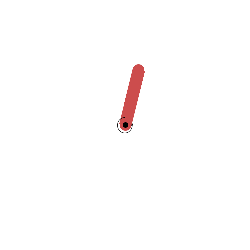

In [19]:
#|eval:false
learner.validate(batches=300)

In [ ]:
#|hide
#|eval: false
!nbdev_export